# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10.

In [1]:
import tensorflow as tf
import os

from tqdm import tqdm_notebook

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [2]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

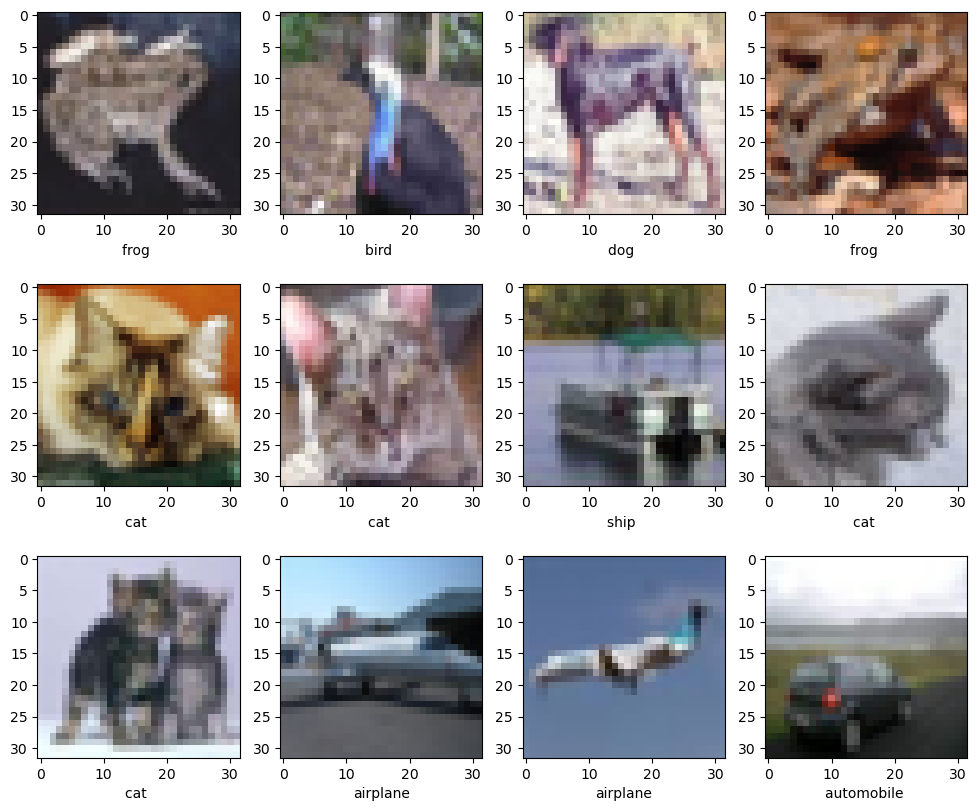

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [4]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [5]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [6]:
import keras
from keras import layers as L
from keras import backend as K

In [7]:
print(keras.__version__)
print(tf.__version__)

2.13.1
2.13.0


In [8]:
# tf.random.set_seed(9)
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
])

In [9]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

1/1 [==============================] - 4s 4s/step
Успех!


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32, 32, 32)        128       
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 32)                1048608   
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 1050122 (4.01 MB)
Trainable params: 1050122 (4.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


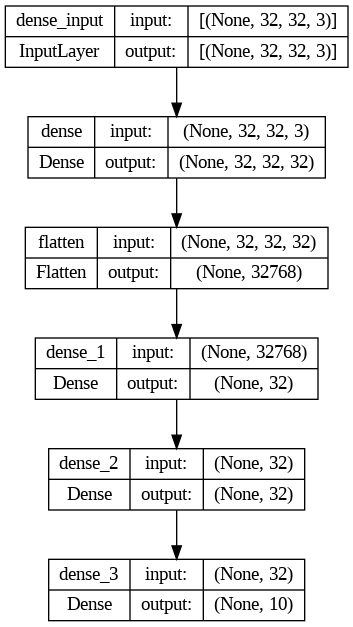

In [21]:
keras.utils.plot_model(model, show_shapes=True)

## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [10]:
y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

In [11]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
             tf.keras.callbacks.TensorBoard(log_dir='./logs'),
             tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                              min_delta=0,
                                              patience=2,
                                              restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy',
                                                  factor=0.1,
                                                  patience=2,
                                                  verbose=0,
                                                  mode='auto',
                                                  min_delta=0,
                                                  cooldown=2,
                                                  min_lr=1e-10)
             ]

In [ ]:
## TODO
model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=64,
                    epochs=16, callbacks=callbacks, validation_split=0.2)

Epoch 1/16
500/500 [==============================] - 4s 5ms/step - loss: 2.1138 - accuracy: 0.1927 - val_loss: 1.8672 - val_accuracy: 0.3026 - lr: 0.0010
Epoch 2/16
 29/500 [>.............................] - ETA: 1s - loss: 1.8425 - accuracy: 0.3033

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - 2s 4ms/step - loss: 1.7722 - accuracy: 0.3392 - val_loss: 1.6871 - val_accuracy: 0.3856 - lr: 0.0010
Epoch 3/16
500/500 [==============================] - 3s 6ms/step - loss: 1.6226 - accuracy: 0.4080 - val_loss: 1.6451 - val_accuracy: 0.4066 - lr: 0.0010
Epoch 4/16
500/500 [==============================] - 2s 4ms/step - loss: 1.5533 - accuracy: 0.4398 - val_loss: 1.5793 - val_accuracy: 0.4338 - lr: 0.0010
Epoch 5/16
500/500 [==============================] - 2s 4ms/step - loss: 1.5076 - accuracy: 0.4573 - val_loss: 1.5614 - val_accuracy: 0.4439 - lr: 0.0010
Epoch 6/16
500/500 [==============================] - 2s 4ms/step - loss: 1.4736 - accuracy: 0.4699 - val_loss: 1.5381 - val_accuracy: 0.4531 - lr: 0.0010
Epoch 7/16
500/500 [==============================] - 2s 4ms/step - loss: 1.4477 - accuracy: 0.4789 - val_loss: 1.5167 - val_accuracy: 0.4666 - lr: 0.0010
Epoch 8/16
500/500 [==============================] - 2s 4ms/step - loss: 1.4196 

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [ ]:
from sklearn.metrics import accuracy_score

predict_x=model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 1s 2ms/step

 Test_acc = 0.4644
 Not bad!


In [ ]:
history.history

{'loss': [2.113837242126465,
  1.7722080945968628,
  1.6225556135177612,
  1.553314208984375,
  1.507584810256958,
  1.4736214876174927,
  1.447713017463684,
  1.4195923805236816,
  1.4032042026519775,
  1.384320855140686,
  1.3734259605407715,
  1.3539152145385742,
  1.3391388654708862,
  1.3254977464675903,
  1.3106763362884521,
  1.2918897867202759],
 'accuracy': [0.1927187442779541,
  0.33921873569488525,
  0.40803125500679016,
  0.4397812485694885,
  0.4573437571525574,
  0.4699062407016754,
  0.4788750112056732,
  0.4893124997615814,
  0.4973750114440918,
  0.5044687390327454,
  0.5074687600135803,
  0.5157187581062317,
  0.5202812552452087,
  0.5256562232971191,
  0.5314062237739563,
  0.5405312776565552],
 'val_loss': [1.8672157526016235,
  1.6871260404586792,
  1.6450581550598145,
  1.5792509317398071,
  1.561444878578186,
  1.5380828380584717,
  1.516703724861145,
  1.5288658142089844,
  1.50462806224823,
  1.5196739435195923,
  1.5140255689620972,
  1.5336341857910156,
  1.5

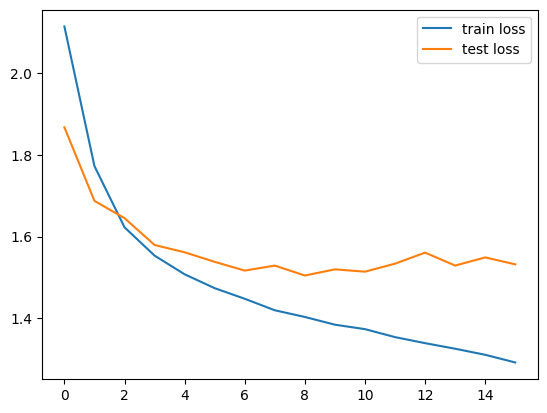

In [ ]:

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend();

Минимальной точности в 0,45 достигли.

Добавил callback ReduceLROnPlateau, задавал patience больше единицы,

иначе не добирался до 45%.

Также установил EarlyStopping(patience=4).

Что явилось улучшающей настройкой, утверждать не берусь пока...

Из графика видно, что сеть переобучается уже к 5-й эпохе.

Сеть неудовлетворительна, с трудом, после нескольких правок смог добиться нужного порога

точности, который сам по себе неудовлетворителен.

Уже после трех запусков смысл работы этой сети терялся, метрики сильно падали на валидации,

что свидетельствует о переобучении.



## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [12]:
## TODO
new_model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=10,
                               kernel_size=(3, 3),
                               padding='same',
                               activation='relu',
                               input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),

        tf.keras.layers.Dense(10, activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation='relu'),

        tf.keras.layers.Dense(10, activation='softmax')])

In [25]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 10)        280       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 10)        0         
 D)                                                              
                                                                 
 dense_4 (Dense)             (None, 16, 16, 10)        110       
                                                                 
 flatten_1 (Flatten)         (None, 2560)              0         
                                                                 
 dense_5 (Dense)             (None, 100)               256100    
                                                                 
 dense_6 (Dense)             (None, 10)                1010      
                                                      

In [13]:
new_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='new_model.{epoch:02d}-{val_loss:.2f}.h5'),
             tf.keras.callbacks.TensorBoard(log_dir='./logs'),
             tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy',
                                                  factor=0.1,
                                                  patience=3,
                                                  verbose=1,
                                                  mode='auto',
                                                  min_delta=0,
                                                  cooldown=3,
                                                  min_lr=1e-10)
                ]

In [ ]:
## TODO
new_model.compile(loss = 'categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
history_2 = new_model.fit(X_train, y_train, batch_size=16,
                          epochs=32, callbacks=new_callbacks,
                          validation_split=0.2)

Epoch 1/32
2000/2000 [==============================] - 12s 5ms/step - loss: 1.6325 - accuracy: 0.4108 - val_loss: 1.5002 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 2/32
  32/2000 [..............................] - ETA: 6s - loss: 1.4139 - accuracy: 0.4883

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2000/2000 [==============================] - 8s 4ms/step - loss: 1.3939 - accuracy: 0.5063 - val_loss: 1.3658 - val_accuracy: 0.5094 - lr: 0.0010
Epoch 3/32
2000/2000 [==============================] - 8s 4ms/step - loss: 1.2723 - accuracy: 0.5493 - val_loss: 1.3755 - val_accuracy: 0.5052 - lr: 0.0010
Epoch 4/32
2000/2000 [==============================] - 9s 4ms/step - loss: 1.1780 - accuracy: 0.5829 - val_loss: 1.2516 - val_accuracy: 0.5614 - lr: 0.0010
Epoch 5/32
2000/2000 [==============================] - 8s 4ms/step - loss: 1.0987 - accuracy: 0.6104 - val_loss: 1.2315 - val_accuracy: 0.5696 - lr: 0.0010
Epoch 6/32
2000/2000 [==============================] - 9s 4ms/step - loss: 1.0308 - accuracy: 0.6353 - val_loss: 1.2657 - val_accuracy: 0.5524 - lr: 0.0010
Epoch 7/32
2000/2000 [==============================] - 8s 4ms/step - loss: 0.9724 - accuracy: 0.6559 - val_loss: 1.2538 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 8/32
2000/2000 [==============================] - 10s 5ms/step 

In [ ]:
history_2.history;

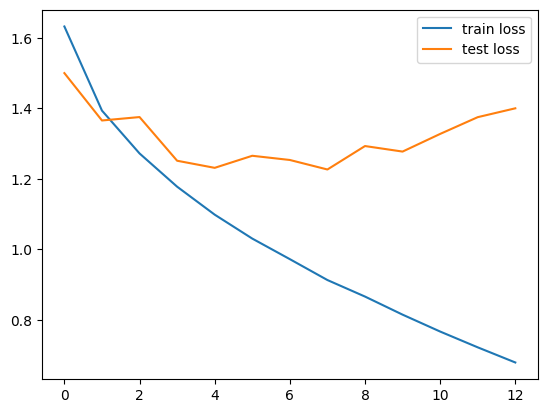

In [ ]:
plt.plot(history_2.history['loss'], label='train loss')
plt.plot(history_2.history['val_loss'], label='test loss')
plt.legend();

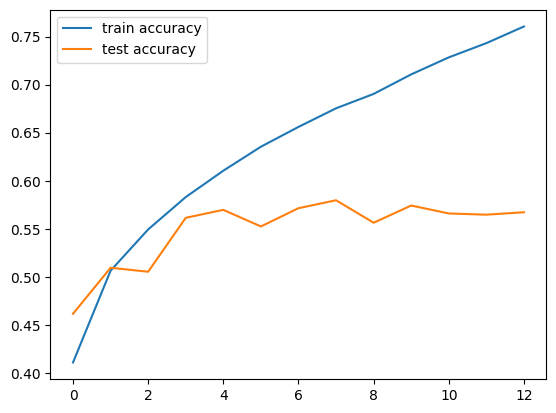

In [ ]:
plt.plot(history_2.history['accuracy'], label='train accuracy')
plt.plot(history_2.history['val_accuracy'], label='test accuracy')
plt.legend();

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [ ]:
from sklearn.metrics import accuracy_score

predict_x = new_model.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 1s 2ms/step

 Test_acc = 0.5836
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций.

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.optimizers import Adam

In [19]:
def train_stand(models_):
    histories = []
    for mod_el in models_:
        mod_el.compile(loss = 'categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
        h = mod_el.fit(X_train, y_train,
                      batch_size=16, epochs=16,
                      callbacks= new_callbacks, validation_split=0.2)
        histories.append(h)

    for h in histories:
        plt.plot(h.history['accuracy'],
                 label = 'train accuracy ')
        plt.plot(h.history['val_accuracy'],
                 label ='test accuracy')
        plt.legend();

In [15]:
models_ = [model, new_model]

Epoch 1/16
2000/2000 [==============================] - 10s 4ms/step - loss: 1.3487 - accuracy: 0.5173 - val_loss: 1.5890 - val_accuracy: 0.4577 - lr: 0.0010
Epoch 2/16
  33/2000 [..............................] - ETA: 6s - loss: 1.3417 - accuracy: 0.5360

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2000/2000 [==============================] - 8s 4ms/step - loss: 1.3351 - accuracy: 0.5203 - val_loss: 1.5752 - val_accuracy: 0.4471 - lr: 0.0010
Epoch 3/16
2000/2000 [==============================] - 8s 4ms/step - loss: 1.3175 - accuracy: 0.5293 - val_loss: 1.6282 - val_accuracy: 0.4380 - lr: 0.0010
Epoch 4/16
2000/2000 [==============================] - 8s 4ms/step - loss: 1.2990 - accuracy: 0.5381 - val_loss: 1.5866 - val_accuracy: 0.4456 - lr: 0.0010
Epoch 5/16
2000/2000 [==============================] - 9s 4ms/step - loss: 1.2881 - accuracy: 0.5405 - val_loss: 1.6618 - val_accuracy: 0.4372 - lr: 0.0010
Epoch 6/16
2000/2000 [==============================] - 9s 5ms/step - loss: 1.2729 - accuracy: 0.5442 - val_loss: 1.6053 - val_accuracy: 0.4475 - lr: 0.0010
Epoch 7/16
2000/2000 [==============================] - 8s 4ms/step - loss: 1.2563 - accuracy: 0.5517 - val_loss: 1.6021 - val_accuracy: 0.4435 - lr: 0.0010
Epoch 1/16
2000/2000 [==============================] - 10s 4ms/step 

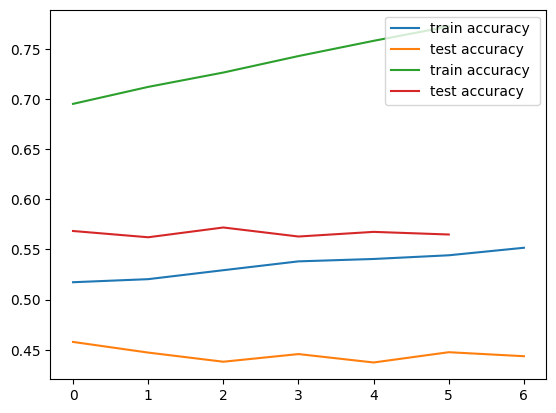

In [ ]:
train_stand(models_)

Видно, что вторая модель получше, чем первая. 

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [21]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, model.predict(X_test).argmax(axis=1))))

In [ ]:
!chcp 65001

Active code page: 65001


In [22]:
!rm -rf ./logs

In [16]:
from sklearn.metrics import accuracy_score
from tensorflow.keras import optimizers

## TODO

optimizers = {'Adam': 'adam', 'SGD': 'SGD'}

In [ ]:
evaluator = Evaluator(new_model, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test, accuracy_score)

<ipython-input-30-e9ddea6ddcac>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):


  0%|          | 0/2 [00:00<?, ?it/s]

313/313 [==============================] - 1s 2ms/step
Final score of single_model_Adam is 0.5268
313/313 [==============================] - 1s 2ms/step
Final score of single_model_SGD is 0.5592


In [ ]:
!pwd

/content


Прокомментируйте полученные результаты.

Вопреки ожиданиям, ADAM отработал хуже SGD. Мнение не моё, опирался на мнения опытных DS-специалистов)

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [23]:
model_fin = Sequential()

model_fin.add(L.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model_fin.add(L.BatchNormalization())
model_fin.add(L.Conv2D(32, (3,3), padding='same', activation='relu'))
model_fin.add(L.BatchNormalization())
model_fin.add(L.MaxPooling2D(pool_size=(2,2)))
model_fin.add(L.Dropout(0.3))

model_fin.add(L.Conv2D(64, (3,3), padding='same', activation='relu'))
model_fin.add(L.BatchNormalization())
model_fin.add(L.Conv2D(64, (3,3), padding='same', activation='relu'))
model_fin.add(L.BatchNormalization())
model_fin.add(L.MaxPooling2D(pool_size=(2,2)))
model_fin.add(L.Dropout(0.3))

model_fin.add(L.Conv2D(128, (3,3), padding='same', activation='relu'))
model_fin.add(L.BatchNormalization())
model_fin.add(L.Conv2D(128, (3,3), padding='same', activation='relu'))
model_fin.add(L.BatchNormalization())
model_fin.add(L.MaxPooling2D(pool_size=(2,2)))
model_fin.add(L.Dropout(0.3))

model_fin.add(L.Flatten())
model_fin.add(L.Dense(128, activation='relu'))
model_fin.add(L.BatchNormalization())
model_fin.add(L.Dropout(0.3))
model_fin.add(L.Dense(10, activation='softmax'))    # classes = 10

model_fin.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_18 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_19 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                      

In [24]:
model_fin.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

In [25]:
history_fin = model_fin.fit(X_train, y_train, batch_size=32,
                          epochs=32, callbacks=callbacks,
                          validation_split=0.2)

Epoch 1/32
1000/1000 [==============================] - 171s 165ms/step - loss: 1.6291 - accuracy: 0.4301 - val_loss: 1.2762 - val_accuracy: 0.5531 - lr: 0.0010
Epoch 2/32
1000/1000 [==============================] - 167s 167ms/step - loss: 1.1111 - accuracy: 0.6068 - val_loss: 0.9692 - val_accuracy: 0.6629 - lr: 0.0010
Epoch 3/32
1000/1000 [==============================] - 166s 166ms/step - loss: 0.9253 - accuracy: 0.6758 - val_loss: 0.8211 - val_accuracy: 0.7128 - lr: 0.0010
Epoch 4/32
1000/1000 [==============================] - 167s 167ms/step - loss: 0.8183 - accuracy: 0.7144 - val_loss: 0.8759 - val_accuracy: 0.7031 - lr: 0.0010
Epoch 5/32
1000/1000 [==============================] - 168s 168ms/step - loss: 0.7455 - accuracy: 0.7405 - val_loss: 0.7869 - val_accuracy: 0.7301 - lr: 0.0010
Epoch 6/32
1000/1000 [==============================] - 170s 170ms/step - loss: 0.6733 - accuracy: 0.7665 - val_loss: 0.7775 - val_accuracy: 0.7374 - lr: 0.0010
Epoch 7/32
1000/1000 [============

313/313 [==============================] - 14s 43ms/step

 Test_acc = 0.8412
Это победа!


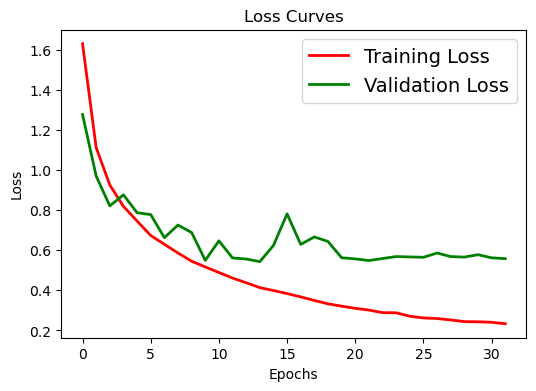

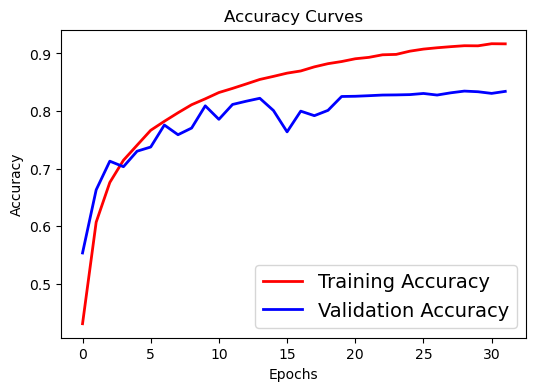

In [26]:
plt.figure(figsize=[6,4])
plt.plot(history_fin.history['loss'], 'red', linewidth=2.0)
plt.plot(history_fin.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

plt.figure(figsize=[6,4])
plt.plot(history_fin.history['accuracy'], 'red', linewidth=2.0)
plt.plot(history_fin.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

from sklearn.metrics import accuracy_score

predict_x=model_fin.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

На данный момент эта модель показывает самый высокий результат. Кривые трейна и валидации гораздо ближе друг другу, чем на предыдущих моделях. 
Больше слоёв и больше нейронов. 


In [29]:
model_fin_ = Sequential()

model_fin_.add(L.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model_fin_.add(L.BatchNormalization())
model_fin_.add(L.Conv2D(32, (3,3), padding='same', activation='relu'))
model_fin_.add(L.BatchNormalization())
model_fin_.add(L.MaxPooling2D(pool_size=(2,2)))
model_fin_.add(L.Dropout(0.5))

model_fin_.add(L.Conv2D(64, (3,3), padding='same', activation='relu'))
model_fin_.add(L.BatchNormalization())
model_fin_.add(L.Conv2D(64, (3,3), padding='same', activation='relu'))
model_fin_.add(L.BatchNormalization())
model_fin_.add(L.MaxPooling2D(pool_size=(2,2)))
model_fin_.add(L.Dropout(0.5))

model_fin_.add(L.Conv2D(128, (3,3), padding='same', activation='relu'))
model_fin_.add(L.BatchNormalization())
model_fin_.add(L.Conv2D(128, (3,3), padding='same', activation='relu'))
model_fin_.add(L.BatchNormalization())
model_fin_.add(L.MaxPooling2D(pool_size=(2,2)))
model_fin_.add(L.Dropout(0.5))

model_fin_.add(L.Flatten())
model_fin_.add(L.Dense(128, activation='relu'))
model_fin_.add(L.BatchNormalization())
model_fin_.add(L.Dropout(0.5))
model_fin_.add(L.Dense(10, activation='softmax'))    # classes = 10

model_fin_.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_32 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_33 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                      

In [30]:
model_fin_.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

history_fin_ = model_fin_.fit(X_train, y_train, batch_size=32,
                          epochs=32, callbacks=callbacks,
                          validation_split=0.2)

Epoch 1/32
1000/1000 [==============================] - ETA: 0s - loss: 1.9084 - accuracy: 0.3446

C:\Users\Johan.DESKTOP-53JNTRO.000\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1000/1000 [==============================] - 171s 164ms/step - loss: 1.9084 - accuracy: 0.3446 - val_loss: 1.5271 - val_accuracy: 0.4552 - lr: 0.0010
Epoch 2/32
1000/1000 [==============================] - 165s 165ms/step - loss: 1.4046 - accuracy: 0.4938 - val_loss: 1.3792 - val_accuracy: 0.5096 - lr: 0.0010
Epoch 3/32
1000/1000 [==============================] - 166s 166ms/step - loss: 1.1990 - accuracy: 0.5766 - val_loss: 1.0018 - val_accuracy: 0.6466 - lr: 0.0010
Epoch 4/32
1000/1000 [==============================] - 166s 166ms/step - loss: 1.0628 - accuracy: 0.6272 - val_loss: 0.9293 - val_accuracy: 0.6704 - lr: 0.0010
Epoch 5/32
1000/1000 [==============================] - 166s 166ms/step - loss: 0.9839 - accuracy: 0.6572 - val_loss: 0.8685 - val_accuracy: 0.6916 - lr: 0.0010
Epoch 6/32
1000/1000 [==============================] - 168s 168ms/step - loss: 0.9200 - accuracy: 0.6789 - val_loss: 0.7396 - val_accuracy: 0.7404 - lr: 0.0010
Epoch 7/32
1000/1000 [=======================

313/313 [==============================] - 14s 42ms/step

 Test_acc = 0.8266
Это победа!


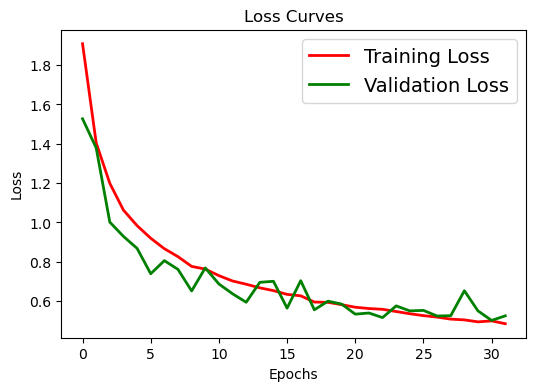

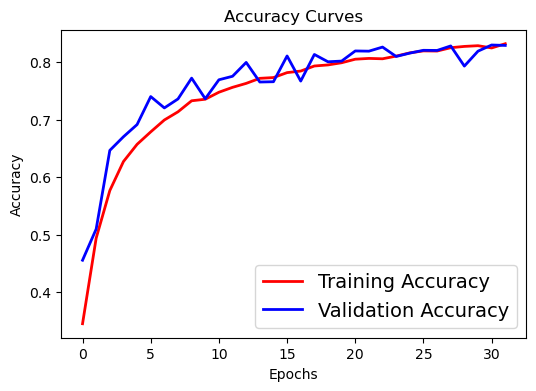

In [31]:
plt.figure(figsize=[6,4])
plt.plot(history_fin_.history['loss'], 'red', linewidth=2.0)
plt.plot(history_fin_.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

plt.figure(figsize=[6,4])
plt.plot(history_fin_.history['accuracy'], 'red', linewidth=2.0)
plt.plot(history_fin_.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

predict_x=model_fin_.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

Здесь я только увеличил DropOut. 
И, хотя, точность на тесте ниже, чем у предыдущей модели, однако, кривые трейна и теста еще ближе. И в некоторых точках они пересекаются и даже совпадают на небольших участках

In [41]:
model_finf = Sequential()

model_finf.add(L.Conv2D(16, (6,6), padding='same', activation='relu', input_shape=(32,32,3)))
model_finf.add(L.BatchNormalization())
model_finf.add(L.Conv2D(16, (6,6), padding='same', activation='relu'))
model_finf.add(L.BatchNormalization())
model_finf.add(L.MaxPooling2D(pool_size=(2,2)))
model_finf.add(L.Dropout(0.6))

model_finf.add(L.Conv2D(32, (6,6), padding='same', activation='relu'))
model_finf.add(L.BatchNormalization())
model_finf.add(L.Conv2D(32, (6,6), padding='same', activation='relu'))
model_finf.add(L.BatchNormalization())
model_finf.add(L.MaxPooling2D(pool_size=(2,2)))
model_finf.add(L.Dropout(0.6))

model_finf.add(L.Conv2D(128, (6,6), padding='same', activation='relu'))
model_finf.add(L.BatchNormalization())
model_finf.add(L.Conv2D(128, (6,6), padding='same', activation='relu'))
model_finf.add(L.BatchNormalization())
model_finf.add(L.MaxPooling2D(pool_size=(2,2)))
model_finf.add(L.Dropout(0.6))

model_finf.add(L.Flatten())
model_finf.add(L.Dense(128, activation='relu'))
model_finf.add(L.BatchNormalization())
model_finf.add(L.Dropout(0.6))
model_finf.add(L.Dense(10, activation='softmax'))    # classes = 10

model_finf.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 32, 32, 16)        1744      
                                                                 
 batch_normalization_62 (Ba  (None, 32, 32, 16)        64        
 tchNormalization)                                               
                                                                 
 conv2d_58 (Conv2D)          (None, 32, 32, 16)        9232      
                                                                 
 batch_normalization_63 (Ba  (None, 32, 32, 16)        64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 16, 16, 16)        0         
 ng2D)                                                           
                                                     

In [43]:
model_finf.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

history_finf = model_finf.fit(X_train, y_train, batch_size=16,
                          epochs=32, callbacks=callbacks,
                          validation_split=0.2)

Epoch 1/32
2000/2000 [==============================] - 318s 156ms/step - loss: 1.9923 - accuracy: 0.3038 - val_loss: 1.6819 - val_accuracy: 0.3830 - lr: 0.0010
Epoch 2/32
2000/2000 [==============================] - 312s 156ms/step - loss: 1.5312 - accuracy: 0.4457 - val_loss: 1.3255 - val_accuracy: 0.5190 - lr: 0.0010
Epoch 3/32
2000/2000 [==============================] - 312s 156ms/step - loss: 1.3671 - accuracy: 0.5126 - val_loss: 1.1660 - val_accuracy: 0.5813 - lr: 0.0010
Epoch 4/32
2000/2000 [==============================] - 316s 158ms/step - loss: 1.2447 - accuracy: 0.5668 - val_loss: 1.0871 - val_accuracy: 0.6120 - lr: 0.0010
Epoch 5/32
2000/2000 [==============================] - 319s 159ms/step - loss: 1.1694 - accuracy: 0.5922 - val_loss: 1.0791 - val_accuracy: 0.6267 - lr: 0.0010
Epoch 6/32
2000/2000 [==============================] - 310s 155ms/step - loss: 1.1097 - accuracy: 0.6176 - val_loss: 0.9100 - val_accuracy: 0.6848 - lr: 0.0010
Epoch 7/32
2000/2000 [============

313/313 [==============================] - 19s 61ms/step

 Test_acc = 0.7943


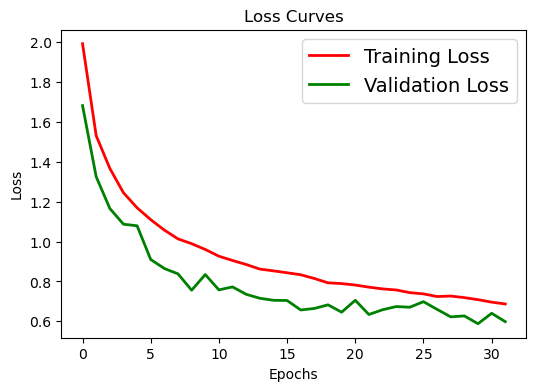

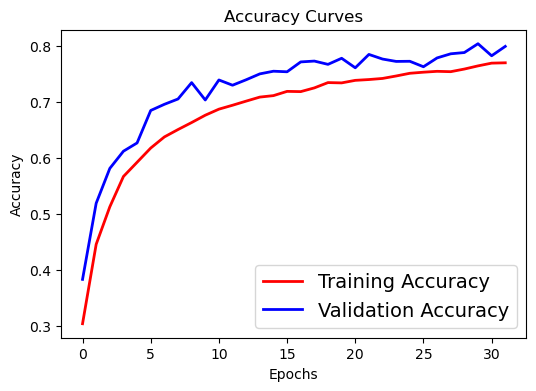

In [44]:
plt.figure(figsize=[6,4])
plt.plot(history_finf.history['loss'], 'red', linewidth=2.0)
plt.plot(history_finf.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

plt.figure(figsize=[6,4])
plt.plot(history_finf.history['accuracy'], 'red', linewidth=2.0)
plt.plot(history_finf.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

predict_x=model_finf.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

Здесь маленький батч, но свертка увеличена в два раза. Считалось долго, но точность ниже предыдущих.

Возможно, на большем количестве эпох точность бы и выросла.

А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов.

Долго, тяжело и пока много белых пятен. 

Надо освоить методы построения моделей с помощью классов (пока с этим есть сложности).

От начала работы за обучение нескольких моделей какое-то понимание пришло.

Теперь я понял как можно жечь процессоры)

Учитывая солидное время на обучение, видимо, придется искать уже зарекомендовавшие себя архитектуры.

Не смог позволить себе применять бОльшее количество эпох, не хватает времени.

Необходимо перенести процессы на GPU (ну и купить достойную).

Много чего не реализовал, к сожалению... 